In [2]:
!pip install shap


                                              0.0/544.4 kB ? eta -:--:--
     --                                    30.7/544.4 kB 660.6 kB/s eta 0:00:01
     --                                    41.0/544.4 kB 393.8 kB/s eta 0:00:02
     ----                                  71.7/544.4 kB 491.5 kB/s eta 0:00:01
     ------                                92.2/544.4 kB 581.0 kB/s eta 0:00:01
     ------                                92.2/544.4 kB 581.0 kB/s eta 0:00:01
     ---------                            143.4/544.4 kB 500.5 kB/s eta 0:00:01
     ------------                         184.3/544.4 kB 556.2 kB/s eta 0:00:01
     ------------                         184.3/544.4 kB 556.2 kB/s eta 0:00:01
     ---------------                      235.5/544.4 kB 554.9 kB/s eta 0:00:01
     ---------------                      235.5/544.4 kB 554.9 kB/s eta 0:00:01
     ----------------                     256.0/544.4 kB 524.0 kB/s eta 0:00:01
     --------------------                 307.2

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\hitha sunil\\anaconda3\\Lib\\site-packages\\~umpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.



In [6]:
pip install --user shap


  Using cached shap-0.48.0-cp311-cp311-win_amd64.whl (544 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import shap

In [2]:
# 1. Load data
df = pd.read_csv("C:/Users/hitha sunil/Downloads/archive (28)/HR-Employee-Attrition.csv")  # rename to your file
df.shape, df.columns.tolist()


((1470, 35),
 ['Age',
  'Attrition',
  'BusinessTravel',
  'DailyRate',
  'Department',
  'DistanceFromHome',
  'Education',
  'EducationField',
  'EmployeeCount',
  'EmployeeNumber',
  'EnvironmentSatisfaction',
  'Gender',
  'HourlyRate',
  'JobInvolvement',
  'JobLevel',
  'JobRole',
  'JobSatisfaction',
  'MaritalStatus',
  'MonthlyIncome',
  'MonthlyRate',
  'NumCompaniesWorked',
  'Over18',
  'OverTime',
  'PercentSalaryHike',
  'PerformanceRating',
  'RelationshipSatisfaction',
  'StandardHours',
  'StockOptionLevel',
  'TotalWorkingYears',
  'TrainingTimesLastYear',
  'WorkLifeBalance',
  'YearsAtCompany',
  'YearsInCurrentRole',
  'YearsSinceLastPromotion',
  'YearsWithCurrManager'])

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64


Text(0.5, 1.0, 'Attrition distribution')

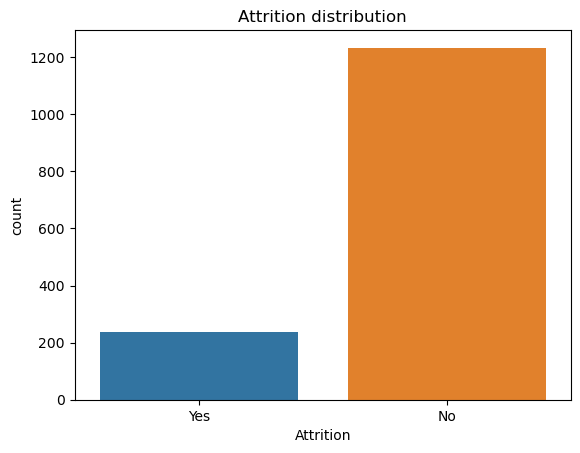

In [3]:
# 2. Quick EDA
print(df['Attrition'].value_counts(normalize=True))
sns.countplot(x='Attrition', data=df);
plt.title('Attrition distribution')


In [4]:
# 3. Basic feature engineering & selection
# Target -> 0/1
df['AttritionFlag'] = df['Attrition'].map({'Yes':1, 'No':0})

# Drop ID-like or redundant cols (if present)
cols_to_drop = ['EmployeeCount','EmployeeNumber','Over18','StandardHours','Attrition']
df = df.drop([c for c in cols_to_drop if c in df.columns], axis=1)

# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('AttritionFlag')
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()


In [5]:
# 4. Train/test split
X = df.drop('AttritionFlag', axis=1)
y = df['AttritionFlag']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [6]:
# 5. Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


In [7]:
# 6. Model pipelines
pipe_lr = Pipeline(steps=[('pre', preprocessor),
                          ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])

pipe_rf = Pipeline(steps=[('pre', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))])


C:\Users\hitha sunil\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


--- LogisticRegression ---
              precision    recall  f1-score   support

           0     0.9183    0.7733    0.8396       247
           1     0.3488    0.6383    0.4511        47

    accuracy                         0.7517       294
   macro avg     0.6336    0.7058    0.6453       294
weighted avg     0.8272    0.7517    0.7775       294

ROC AUC: 0.8028


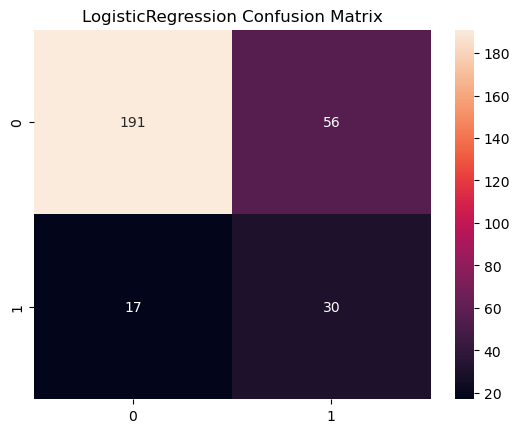

C:\Users\hitha sunil\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


--- RandomForest ---
              precision    recall  f1-score   support

           0     0.8531    0.9879    0.9156       247
           1     0.6250    0.1064    0.1818        47

    accuracy                         0.8469       294
   macro avg     0.7391    0.5471    0.5487       294
weighted avg     0.8167    0.8469    0.7983       294

ROC AUC: 0.7832


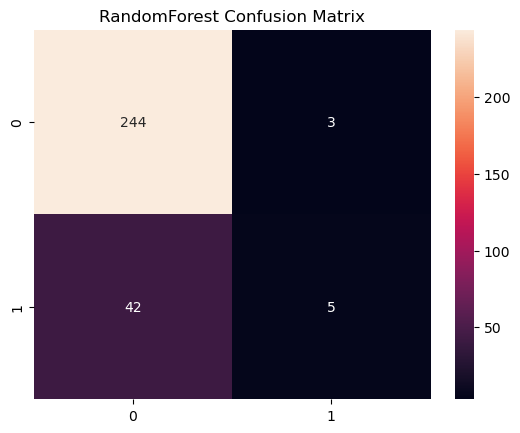

In [8]:
# 7. Fit & evaluate
for name, pipe in [('LogisticRegression', pipe_lr), ('RandomForest', pipe_rf)]:
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:,1]
    print(f"--- {name} ---")
    print(classification_report(y_test, preds, digits=4))
    print("ROC AUC:", round(roc_auc_score(y_test, probs),4))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d'); plt.title(name + ' Confusion Matrix'); plt.show()


C:\Users\hitha sunil\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


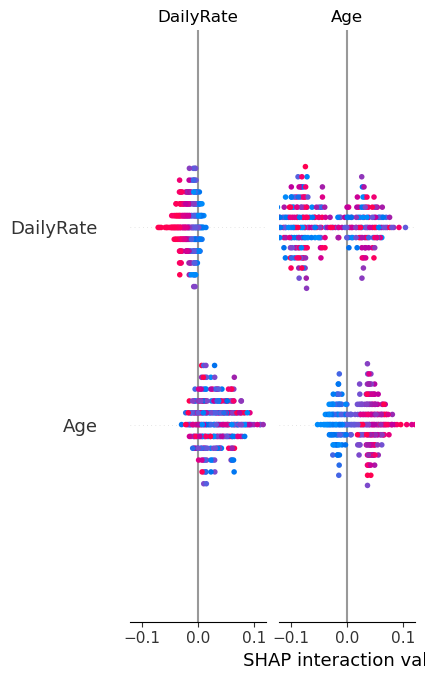

In [10]:
# 8. SHAP explainability (fixed version for RandomForest)

# Fit preprocessor
preprocessor.fit(X_train)

# Transform data
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# Build feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_feature_names)

# Train Random Forest on transformed data
rf_raw = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_raw.fit(X_train_trans, y_train)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_raw)
shap_values = explainer.shap_values(X_test_trans)

# ✅ Handle binary classification (shap_values is a list of 2 arrays)
# If it's a list, use shap_values[1]; if not, use shap_values directly
if isinstance(shap_values, list):
    shap_array = shap_values[1]
else:
    shap_array = shap_values

# Summary plot (global feature importance)
shap.summary_plot(shap_array, X_test_trans, feature_names=feature_names)


🧩 Employees showing career stagnation risk: 15


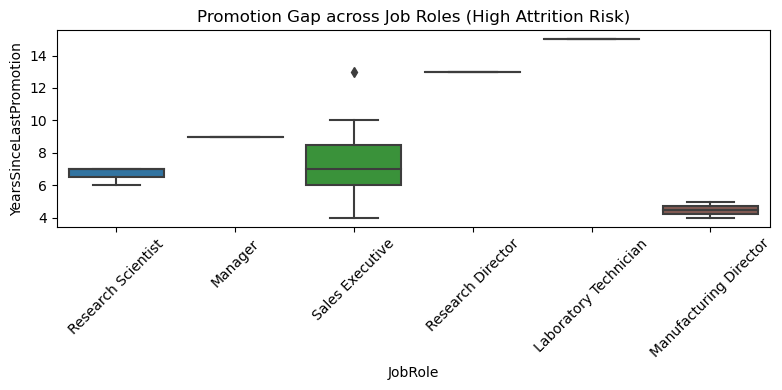

💼 Employees working overtime but earning below-median income: 202


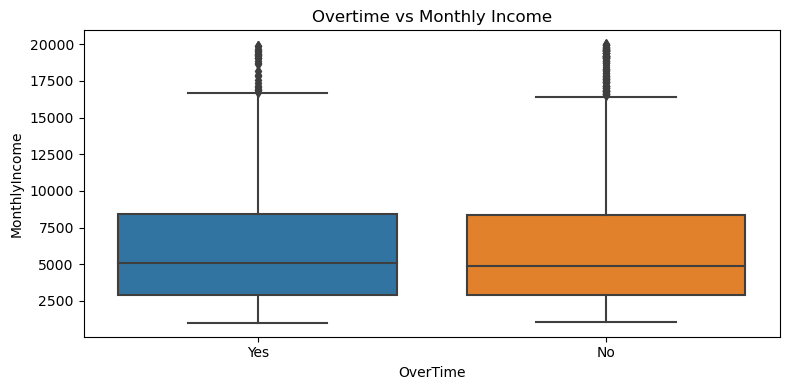

🚗 Employees with long commutes at attrition risk: 58


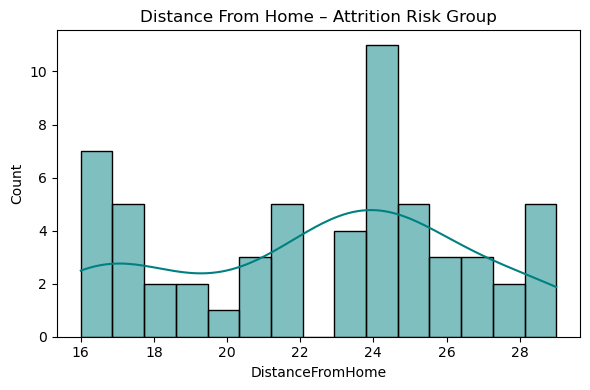


📋 Final Business Recommendations:
- 🎯 Introduce career development programs for employees with >3 years since last promotion.
- 💸 Review overtime policies and salary bands for underpaid high-load employees.
- 🏠 Implement hybrid or remote options for staff living >15 km away to reduce burnout.


In [14]:
# -----------------------------
# HR Attrition – Business Insights & Actions
# -----------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# 1️⃣ Load dataset
df = pd.read_csv("C:/Users/hitha sunil/Downloads/archive (28)/HR-Employee-Attrition.csv")

# 2️⃣ Prepare features and target
target = "Attrition"
y = df[target].map({"Yes": 1, "No": 0})
X = df.drop(columns=[target])

# 3️⃣ Define numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# 4️⃣ Build preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# 5️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6️⃣ Train RandomForest model
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf.fit(preprocessor.fit_transform(X_train), y_train)

# 7️⃣ Make predictions on full data for insight visualization
df['PredictedAttrition'] = rf.predict(preprocessor.transform(X))

# -----------------------------
# 📊 INSIGHT 1 – Career stagnation and low satisfaction
# -----------------------------
stagnant = df[
    (df['YearsSinceLastPromotion'] > 3) &
    (df['JobSatisfaction'] <= 2) &
    (df['PredictedAttrition'] == 1)
]
print(f"🧩 Employees showing career stagnation risk: {len(stagnant)}")

plt.figure(figsize=(8, 4))
sns.boxplot(data=stagnant, x='JobRole', y='YearsSinceLastPromotion')
plt.title("Promotion Gap across Job Roles (High Attrition Risk)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# 💰 INSIGHT 2 – Compensation gap & overtime load
# -----------------------------
overtime_risk = df[
    (df['OverTime'] == 'Yes') &
    (df['MonthlyIncome'] < df['MonthlyIncome'].median())
]
print(f"💼 Employees working overtime but earning below-median income: {len(overtime_risk)}")

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='OverTime', y='MonthlyIncome')
plt.title("Overtime vs Monthly Income")
plt.tight_layout()
plt.show()

# -----------------------------
# 🏠 INSIGHT 3 – Long commute flexibility suggestion
# -----------------------------
commute_risk = df[
    (df['DistanceFromHome'] > 15) &
    (df['PredictedAttrition'] == 1)
]
print(f"🚗 Employees with long commutes at attrition risk: {len(commute_risk)}")

plt.figure(figsize=(6, 4))
sns.histplot(commute_risk['DistanceFromHome'], bins=15, kde=True, color='teal')
plt.title("Distance From Home – Attrition Risk Group")
plt.tight_layout()
plt.show()

# -----------------------------
# 🧠 Final summarized business suggestions
# -----------------------------
suggestions = [
    "🎯 Introduce career development programs for employees with >3 years since last promotion.",
    "💸 Review overtime policies and salary bands for underpaid high-load employees.",
    "🏠 Implement hybrid or remote options for staff living >15 km away to reduce burnout."
]

print("\n📋 Final Business Recommendations:")
for s in suggestions:
    print("-", s)
